In [92]:
cd hanhwa

/home/shkim/hanhwa


In [94]:
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
# dataset = read_csv('./data/pollution1.csv', header=0, index_col=0)
# values = dataset['pollution'].values

from function_file.time_series import time_series_dataframe
DATA= time_series_dataframe()



,TEMP,label,TIME
0,286.797,1,0
1,287.082,1,1
2,285.938,1,2
3,285.772,1,3
4,286.357,1,4
...,...,...,...
906535,768.756,9,906535
906536,768.964,9,906536
906537,768.936,9,906537
906538,769.067,9,906538


In [69]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [70]:
from pandas import DataFrame
from pandas import concat
import numpy as np
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [71]:
encoder = LabelEncoder()
values = encoder.fit_transform(values)

# ensure all data is float
values = values.astype('float32')
values = values.reshape(-1,1)
values.shape

(43800, 1)

In [96]:
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

# specify the number of lag hours
# frame as supervised learning
values = DATA['TEMP'].values
values = values.reshape(-1,1)
reframed = series_to_supervised(values, 100, 60)

In [97]:
reframed_values = reframed.values

In [98]:
n_train_hours = int(len(reframed_values)*0.7)
train = reframed_values[:n_train_hours]
test = reframed_values[n_train_hours:]

In [99]:
train.shape, test.shape

((634466, 160), (271915, 160))

In [100]:
X_train, y_train = train[:, :100], train[:, 100:]

In [101]:
X_test, y_test = test[:, :100], test[:, 100:]

In [102]:
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
train_X = scaler_train.fit_transform(X_train)
train_y = scaler_train.fit_transform(y_train)
test_X = scaler_test.fit_transform(X_test)
test_y = scaler_test.fit_transform(y_test)

In [103]:
n_hours = 100
n_features = 1
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape:\n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


train_X.shape, train_y.shape, test_X.shape, test_y.shape:
 (634466, 100, 1) (634466, 60) (271915, 100, 1) (271915, 60)


In [104]:
lr = 0.0001
EPOCHS = 100
model = Sequential()
model.add(LSTM(65, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(train_y.shape[1]))
# model.summary()
model.compile(
              optimizer=Adam(learning_rate=lr, ),
              loss='mse',
              metrics=['mae'])

history = model.fit(train_X, train_y,
                    epochs=EPOCHS,
                    batch_size=512,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False)

Epoch 1/100
1240/1240 - 7s - loss: 0.0090 - mae: 0.0648 - val_loss: 0.0059 - val_mae: 0.0580 - 7s/epoch - 6ms/step
Epoch 2/100
1240/1240 - 6s - loss: 0.0031 - mae: 0.0340 - val_loss: 6.6441e-04 - val_mae: 0.0170 - 6s/epoch - 5ms/step
Epoch 3/100
1240/1240 - 6s - loss: 0.0021 - mae: 0.0270 - val_loss: 0.0037 - val_mae: 0.0480 - 6s/epoch - 5ms/step
Epoch 4/100
1240/1240 - 6s - loss: 0.0016 - mae: 0.0233 - val_loss: 0.0049 - val_mae: 0.0546 - 6s/epoch - 5ms/step
Epoch 5/100
1240/1240 - 6s - loss: 0.0013 - mae: 0.0207 - val_loss: 0.0030 - val_mae: 0.0408 - 6s/epoch - 5ms/step
Epoch 6/100
1240/1240 - 6s - loss: 0.0010 - mae: 0.0185 - val_loss: 0.0024 - val_mae: 0.0348 - 6s/epoch - 5ms/step
Epoch 7/100
1240/1240 - 6s - loss: 9.2002e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0273 - 6s/epoch - 5ms/step
Epoch 8/100
1240/1240 - 6s - loss: 8.2603e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0246 - 6s/epoch - 5ms/step
Epoch 9/100
1240/1240 - 6s - loss: 7.6298e-04 - mae: 0.0154 - val_lo

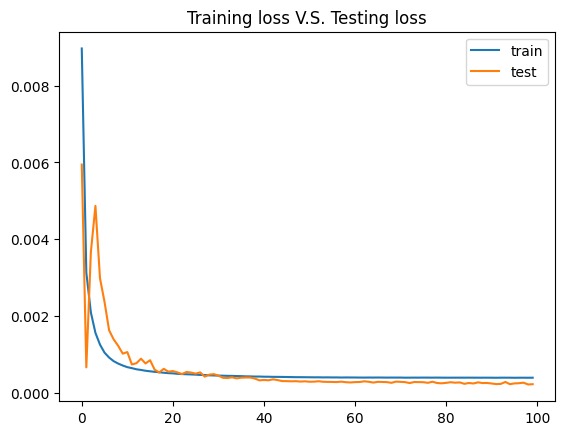

In [106]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
plt.title("Training loss V.S. Testing loss")
pyplot.show()

In [107]:
yhat = model.predict(test_X)
print("yhat.shape:", yhat.shape)

test_X = test_X.reshape((test_X.shape[0], n_hours * n_features))
print("test_X.shape:", test_X.shape)

8498/8498 [==============================] - 9s 1ms/step
yhat.shape: (271915, 60)
test_X.shape: (271915, 100)


In [108]:
inv_yhat = scaler_test.inverse_transform(yhat)
inv_yhat = inv_yhat.reshape((-1, 1))

# invert scaling for actual
print("test_y.shape", test_y.shape)
test_y = test_y.reshape((len(test_y), 60))
print("test_y.shape", test_y.shape)
# inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, 0]

inv_y = scaler_test.inverse_transform(test_y)
inv_y = inv_y.reshape((-1, 1))

test_y.shape (271915, 60)
test_y.shape (271915, 60)


In [109]:
inv_y = scaler_test.inverse_transform(test_y)
inv_y = inv_y.reshape((-1, 1))


In [110]:
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)


Test RMSE: 7.738
Test MAE: 5.381


In [111]:
inv_yhat = inv_yhat.reshape((-1, 1))
inv_y = inv_y.reshape((-1, 1))

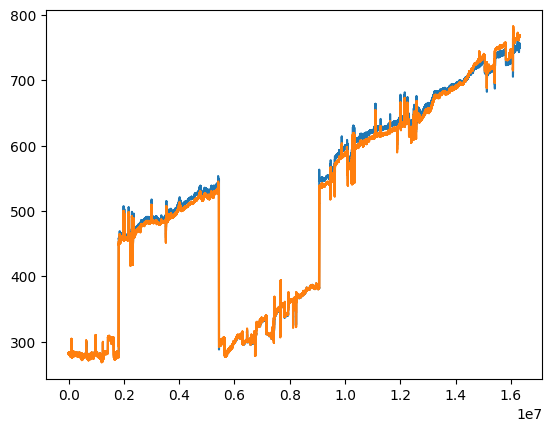

In [112]:
plt.plot(inv_yhat, label='predict')
plt.plot(inv_y, label = 'actual')

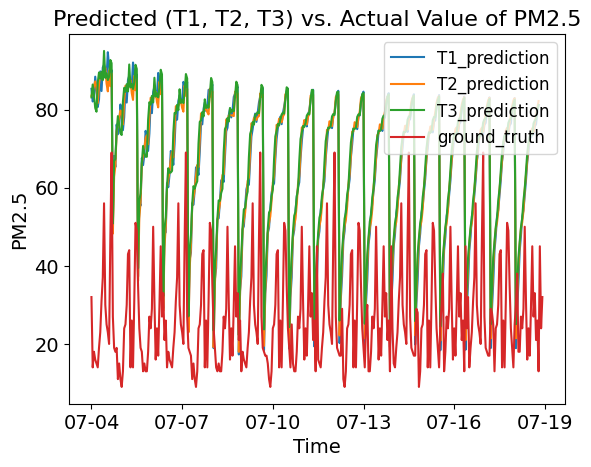

In [105]:
dates = ['07-04', '07-07', '07-10', '07-13', '07-16', '07-19']

# plot Prediction V.S. actual value of PM2.5
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.plot(inv_yhat[23:379, 0], label='T1_prediction')
plt.plot(inv_yhat[23:379, 1], label='T2_prediction')
plt.plot(inv_yhat[23:379, 2], label='T3_prediction')
plt.plot(inv_y[20:379, 0], label='ground_truth')
plt.xlabel("Time", fontsize='14')
plt.ylabel("PM2.5", fontsize='14')
plt.xticks(np.arange(0, 361, 72), dates, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Predicted (T1, T2, T3) vs. Actual Value of PM2.5', fontsize=16)
plt.legend(prop={"size": 12}, loc='upper right')
plt.show()
plt.close()

# 전체 데이터

In [56]:
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
# load dataset
dataset = read_csv('data/pollution1.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])

# ensure all data is float
values = values.astype('float32')

# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_hours = 4*24
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, 3)
# print(reframed.shape)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*0.6998)
train = reframed_values[:n_train_hours, :]
test = reframed_values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, [-n_features*3, -n_features*2, -n_features]]
test_X, test_y = test[:, :n_obs], test[:, [-n_features*3, -n_features*2, -n_features]]

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)
print("train_X.shape, train_y.shape:", train_X.shape, train_y.shape)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape:\n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
lr = 0.00001
EPOCHS = 250
model = Sequential()
model.add(LSTM(65, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(train_y.shape[1]))
model.summary()
model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss='mse',
    metrics=['mae']
)


train_X.shape, train_y.shape: (30582, 768) (30582, 3)
train_X.shape, train_y.shape, test_X.shape, test_y.shape:
 (30582, 96, 8) (30582, 3) (13120, 96, 8) (13120, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 65)                19240     
                                                                 
 dropout_2 (Dropout)         (None, 65)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 198       
                                                                 
Total params: 19438 (75.93 KB)
Trainable params: 19438 (75.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import warnings
warnings.filterwarnings('ignore')
history = model.fit(train_X, train_y,
                    epochs=100,
                    batch_size=512,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
plt.title("Training loss V.S. Testing loss")
# plt.savefig('./graph/rnn_loss.png', dpi=300)
pyplot.show()

In [59]:
yhat = model.predict(test_X)
print("yhat.shape:", yhat.shape)

test_X = test_X.reshape((test_X.shape[0], n_hours * n_features))
print("test_X.shape:", test_X.shape)


410/410 [==============================] - 1s 1ms/step
yhat.shape: (13120, 3)
test_X.shape: (13120, 768)


In [63]:
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat = inv_yhat.reshape((-1, 1))


In [61]:
print("test_y.shape", test_y.shape)

test_y.shape (13120, 3)


In [62]:
test_y = test_y.reshape((len(test_y), 3))
print("test_y.shape", test_y.shape)
# inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, 0]

inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y.reshape((-1, 1))

test_y.shape (13120, 3)


In [64]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)


Test RMSE: 35.581
Test MAE: 20.568


In [65]:
inv_yhat = inv_yhat.reshape((-1, 3))
inv_y = inv_y.reshape((-1, 3))